# Intra-document masking

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from itertools import chain
from typing import Dict, List, Any
from timeit import default_timer as timer
from tqdm import tqdm

from datasets import Dataset, load_from_disk
from transformers import AutoTokenizer

In [3]:
def intra_doc_causal_mask(doc_boundaries: list, max_seq_length: int, device='cpu') -> torch.Tensor:
    """Create a block diagonal causal mask for the intra-document segments."""

    if sum(doc_boundaries) != max_seq_length:
        raise ValueError("Sum of doc_boundaries does not match max_seq_length.")

    # Create a causal mask for each segment in doc_boundaries (lower triangle is True, upper is False)
    sub_masks_bool = []
    for segment_length in doc_boundaries:
        segment_causal_mask_bool = torch.tril(torch.ones(
            (segment_length, segment_length), dtype=torch.bool, device=device
        ))
        sub_masks_bool.append(segment_causal_mask_bool)

    # Use torch.block_diag to combine single masks into a block diagonal mask.
    # This creates a matrix where sub_masks are on the diagonal, and off-diagonal blocks are False.
    block_diagonal_mask_bool = torch.block_diag(*sub_masks_bool)

    return block_diagonal_mask_bool

In [5]:
# Load chunked dataset with token boundaries
train_set = load_from_disk("/fast/najroldi/data/lm/fwedu/fwedu_sample_10B_tokenizer_GPT2/ctx_2048/train")
max_seq_len = 2048+1

In [ ]:
ii = 1024
# ii = 1025
# ii = 1027

text = train_set[ii]['input_ids']
docs_lengths = train_set[ii]['docs_lengths']

tokenizer = AutoTokenizer.from_pretrained('gpt2')

tokenizer.decode(text)
mask = intra_doc_causal_mask(train_set[0]['docs_lengths'], 2049, device='cuda')


/home/najroldi/miniconda3/envs/plainLM/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [77]:
# build mask and move to CPU+NumPy
mask = intra_doc_causal_mask(docs_lengths, len(text), device='cuda').cpu().numpy()

# decode all tokens
decoded_tokens = [tokenizer.decode(token) for token in text]

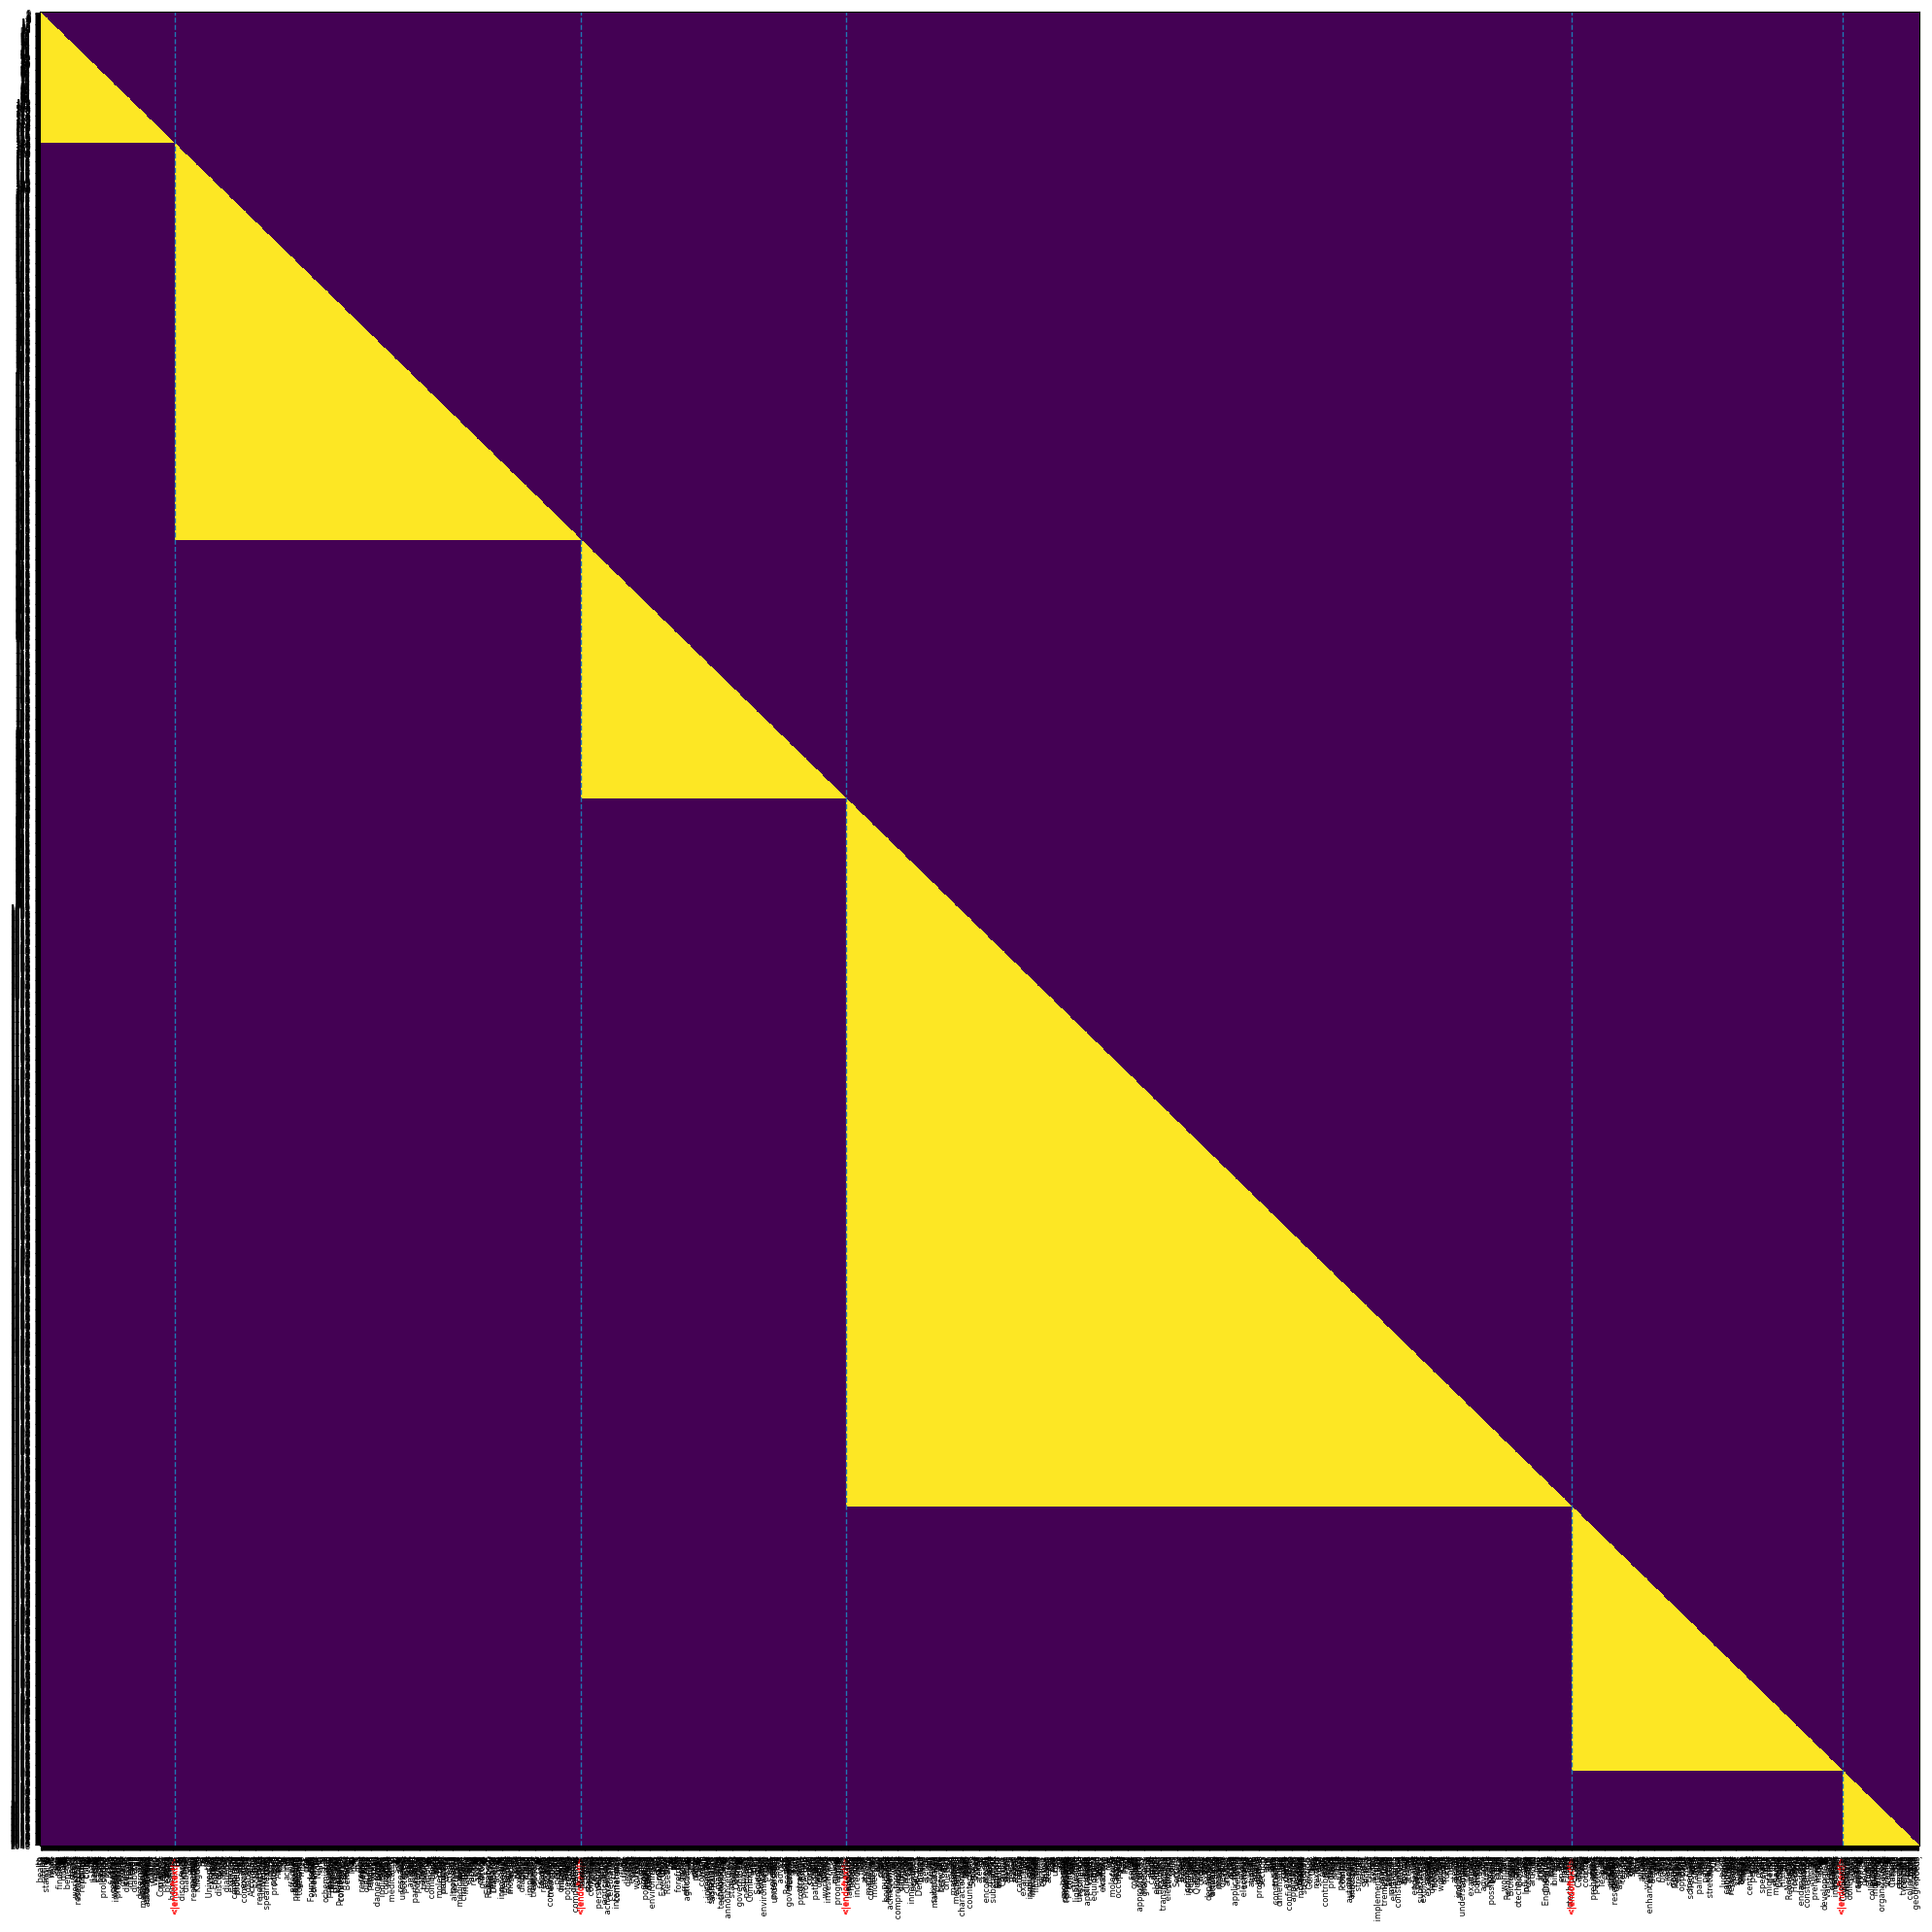

In [78]:
# plot
fig, ax = plt.subplots(figsize=(20, 20), dpi=100)
ax.imshow(mask, aspect='auto', interpolation='none')

# draw vertical boundary lines
boundaries = np.cumsum(docs_lengths)[:-1]  # drop the last, since it’s the end of the seq
for b in boundaries:
    ax.axvline(x=b - 0.5, linestyle='--', linewidth=1)

# subsample tick labels
step = 1
idxs = list(range(0, len(decoded_tokens), step))
ax.set_xticks(idxs)
ax.set_xticklabels([decoded_tokens[i] for i in idxs], rotation=90, fontsize=6)
for lbl in ax.get_xticklabels():
    if lbl.get_text() == tokenizer.eos_token:
        lbl.set_color('red')
ax.set_yticks(idxs)
ax.set_yticklabels(idxs, fontsize=6)

plt.tight_layout()
plt.show()

## save as infinite-zoom SVG
# fig.savefig("intra_doc_mask.svg", format="svg", bbox_inches="tight")